In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Mon Jan 22 10:24:48 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   53C    P0   259W / 300W |  27899MiB / 80994MiB |      8%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_randn_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = -3
hp.const_sigma = True
hp.quantize = False
hp.prior_mu = 0.999

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_0.999_1e-5/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if True:
    step, model_list, optimizer_list = load_model_list(save_dir, 78801, model_list, optimizer_list)

total 77172
-rw-rw-r-- 1 scpark scpark       40  1월 22 10:24 events.out.tfevents.1705886631.GPUSVR11
-rw-rw-r-- 1 scpark scpark     7043  1월 22 10:24 events.out.tfevents.1705886638.GPUSVR11
-rw-rw-r-- 1 scpark scpark       40  1월 22 10:23 events.out.tfevents.1705886603.GPUSVR11
-rw-rw-r-- 1 scpark scpark       40  1월 22 10:23 events.out.tfevents.1705886610.GPUSVR11
-rw-rw-r-- 1 scpark scpark 11691847  1월 22 10:23 events.out.tfevents.1705863404.GPUSVR11
-rw-rw-r-- 1 scpark scpark  7477768  1월 22 10:23 save_78801
-rw-rw-r-- 1 scpark scpark  7477768  1월 22 09:40 save_70000
-rw-rw-r-- 1 scpark scpark  7477768  1월 22 08:51 save_60000
-rw-rw-r-- 1 scpark scpark  7477768  1월 22 08:02 save_50000
-rw-rw-r-- 1 scpark scpark  7477768  1월 22 07:13 save_40000
-rw-rw-r-- 1 scpark scpark  7477768  1월 22 06:23 save_30000
-rw-rw-r-- 1 scpark scpark  7477768  1월 22 05:34 save_20000
-rw-rw-r-- 1 scpark scpark  7477768  1월 22 04:45 save_10000
-rw-rw-r-- 1 scpark scpark  7470716  1월 22 03:57 save_0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

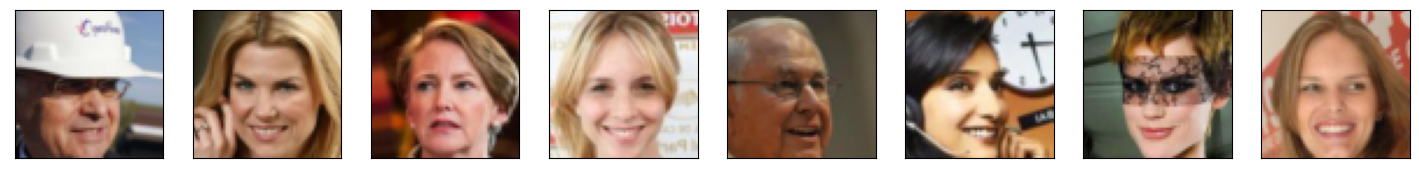

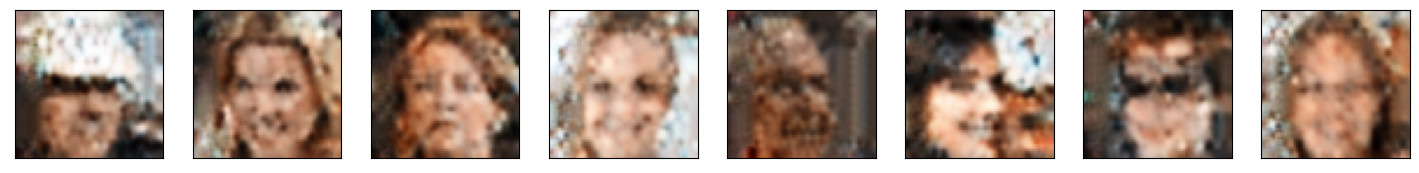

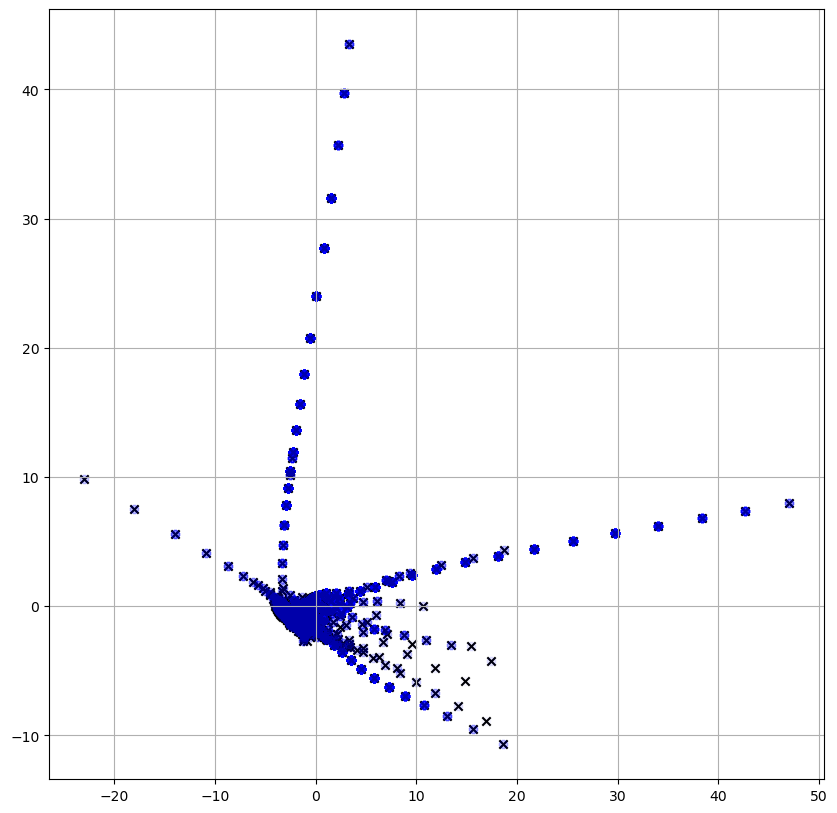

86001
lse_loss -208.7091064453125
commit_loss 0.0032252944074571133
recon_loss 0.00029235263355076313
86002
lse_loss -209.01718139648438
commit_loss 0.0032550536561757326
recon_loss 0.0002966061874758452
86003
lse_loss -209.49545288085938
commit_loss 0.003121416550129652
recon_loss 0.00025649811141192913
86004
lse_loss -208.0364990234375
commit_loss 0.003137233667075634
recon_loss 0.00027768511790782213
86005
lse_loss -209.03060913085938
commit_loss 0.003217704826965928
recon_loss 0.00028534233570098877
86006
lse_loss -208.20364379882812
commit_loss 0.0033295070752501488
recon_loss 0.000335831253323704
86007
lse_loss -206.87701416015625
commit_loss 0.0033524108584970236
recon_loss 0.0002957360993605107
86008
lse_loss -207.60211181640625
commit_loss 0.003090819576755166
recon_loss 0.000277464569080621
86009
lse_loss -207.31689453125
commit_loss 0.0032216114923357964
recon_loss 0.00030644581420347095
86010
lse_loss -208.62863159179688
commit_loss 0.0032103508710861206
recon_loss 0.000295

86082
lse_loss -208.95761108398438
commit_loss 0.0032159914262592793
recon_loss 0.0003148688410874456
86083
lse_loss -208.96572875976562
commit_loss 0.00315887201577425
recon_loss 0.00033273338340222836
86084
lse_loss -208.34664916992188
commit_loss 0.0031912606209516525
recon_loss 0.0003092365514021367
86085
lse_loss -208.49386596679688
commit_loss 0.003142265835776925
recon_loss 0.00030197392334230244
86086
lse_loss -208.62002563476562
commit_loss 0.003246080595999956
recon_loss 0.00033234720467589796
86087
lse_loss -207.88290405273438
commit_loss 0.0032460931688547134
recon_loss 0.0002925943990703672
86088
lse_loss -209.01937866210938
commit_loss 0.003102885792031884
recon_loss 0.00032169625046662986
86089
lse_loss -209.24688720703125
commit_loss 0.0032256629783660173
recon_loss 0.00028088781982660294
86090
lse_loss -208.38388061523438
commit_loss 0.0030927197076380253
recon_loss 0.00030277378391474485
86091
lse_loss -208.81643676757812
commit_loss 0.00311690429225564
recon_loss 0.0

86163
lse_loss -208.74258422851562
commit_loss 0.0031149405986070633
recon_loss 0.00029505876591429114
86164
lse_loss -207.53225708007812
commit_loss 0.003146559000015259
recon_loss 0.00031148805283010006
86165
lse_loss -208.39483642578125
commit_loss 0.003089924342930317
recon_loss 0.0002972292131744325
86166
lse_loss -208.16439819335938
commit_loss 0.00310670118778944
recon_loss 0.00030144662014208734
86167
lse_loss -209.22512817382812
commit_loss 0.0031235506758093834
recon_loss 0.0002879076055251062
86168
lse_loss -205.14187622070312
commit_loss 0.0031214707996696234
recon_loss 0.0003022183373104781
86169
lse_loss -206.67257690429688
commit_loss 0.0032280990853905678
recon_loss 0.00029209634521976113
86170
lse_loss -208.10299682617188
commit_loss 0.003225949127227068
recon_loss 0.000304492365103215
86171
lse_loss -207.69189453125
commit_loss 0.003396578598767519
recon_loss 0.000305264926282689
86172
lse_loss -208.79364013671875
commit_loss 0.0031910163816064596
recon_loss 0.0003070

86245
lse_loss -208.35769653320312
commit_loss 0.003125271759927273
recon_loss 0.00029259384609758854
86246
lse_loss -207.357666015625
commit_loss 0.003311655716970563
recon_loss 0.00032612611539661884
86247
lse_loss -208.08206176757812
commit_loss 0.003252630587667227
recon_loss 0.0003005310136359185
86248
lse_loss -209.03045654296875
commit_loss 0.00315780658274889
recon_loss 0.0002931901253759861
86249
lse_loss -208.26669311523438
commit_loss 0.003141445107758045
recon_loss 0.00027483413578011096
86250
lse_loss -207.02041625976562
commit_loss 0.0030707570258527994
recon_loss 0.00030247302493080497
86251
lse_loss -207.88357543945312
commit_loss 0.003128005424514413
recon_loss 0.00027095910627394915
86252
lse_loss -208.84719848632812
commit_loss 0.003102856455370784
recon_loss 0.00029300322057679296
86253
lse_loss -209.18667602539062
commit_loss 0.003074921201914549
recon_loss 0.00029087881557643414
86254
lse_loss -207.3236083984375
commit_loss 0.003057394875213504
recon_loss 0.000276

86326
lse_loss -208.09780883789062
commit_loss 0.003128533950075507
recon_loss 0.00027250469429418445
86327
lse_loss -207.2574462890625
commit_loss 0.003209818387404084
recon_loss 0.00026956613874062896
86328
lse_loss -209.93795776367188
commit_loss 0.0031106278765946627
recon_loss 0.00027298612985759974
86329
lse_loss -209.46133422851562
commit_loss 0.0032220836728811264
recon_loss 0.0002784483367577195
86330
lse_loss -208.87973022460938
commit_loss 0.003220492973923683
recon_loss 0.00027378552476875484
86331
lse_loss -207.61907958984375
commit_loss 0.003112899139523506
recon_loss 0.00032096041832119226
86332
lse_loss -207.76132202148438
commit_loss 0.003045800607651472
recon_loss 0.0002669483073987067
86333
lse_loss -208.8641357421875
commit_loss 0.0030933688394725323
recon_loss 0.000266470480710268
86334
lse_loss -206.75296020507812
commit_loss 0.0032455972395837307
recon_loss 0.00027537369169294834
86335
lse_loss -207.23953247070312
commit_loss 0.00331568019464612
recon_loss 0.0002

86407
lse_loss -209.5596923828125
commit_loss 0.003060785587877035
recon_loss 0.00028137234039604664
86408
lse_loss -209.241943359375
commit_loss 0.0030975330155342817
recon_loss 0.00030416809022426605
86409
lse_loss -207.75186157226562
commit_loss 0.0031681738328188658
recon_loss 0.0003263341204728931
86410
lse_loss -209.45477294921875
commit_loss 0.003181546926498413
recon_loss 0.0002836909843608737
86411
lse_loss -203.44558715820312
commit_loss 0.0033155265264213085
recon_loss 0.0002892959164455533
86412
lse_loss -209.00009155273438
commit_loss 0.0031347195617854595
recon_loss 0.0002954216324724257
86413
lse_loss -209.03131103515625
commit_loss 0.003126285271719098
recon_loss 0.0002995984395965934
86414
lse_loss -209.2611083984375
commit_loss 0.003077433444559574
recon_loss 0.00028824101900681853
86415
lse_loss -209.54342651367188
commit_loss 0.003092821454629302
recon_loss 0.0003021898155566305
86416
lse_loss -208.7471923828125
commit_loss 0.0031348117627203465
recon_loss 0.0003020

86488
lse_loss -206.18536376953125
commit_loss 0.003269664943218231
recon_loss 0.00031360486173070967
86489
lse_loss -206.92523193359375
commit_loss 0.003186472225934267
recon_loss 0.00034769513877108693
86490
lse_loss -205.37692260742188
commit_loss 0.003552903886884451
recon_loss 0.0003587763640098274
86491
lse_loss -206.90634155273438
commit_loss 0.0035792477428913116
recon_loss 0.00030556684941984713
86492
lse_loss -207.7679443359375
commit_loss 0.0032841789070516825
recon_loss 0.0003354919026605785
86493
lse_loss -207.68408203125
commit_loss 0.003270315006375313
recon_loss 0.000364793639164418
86494
lse_loss -207.79241943359375
commit_loss 0.003141425084322691
recon_loss 0.0003384616575203836
86495
lse_loss -208.33956909179688
commit_loss 0.0031283856369554996
recon_loss 0.00032619870034977794
86496
lse_loss -207.20159912109375
commit_loss 0.0032002730295062065
recon_loss 0.0003314879722893238
86497
lse_loss -207.83981323242188
commit_loss 0.0032042120583355427
recon_loss 0.000332

86569
lse_loss -208.37969970703125
commit_loss 0.003207567147910595
recon_loss 0.00028044841019436717
86570
lse_loss -209.11700439453125
commit_loss 0.0031329444609582424
recon_loss 0.0002729913394432515
86571
lse_loss -208.218017578125
commit_loss 0.0031746625900268555
recon_loss 0.0003422951267566532
86572
lse_loss -209.30108642578125
commit_loss 0.0031371554359793663
recon_loss 0.0003066986973863095
86573
lse_loss -209.10528564453125
commit_loss 0.003240346908569336
recon_loss 0.00031123164808377624
86574
lse_loss -209.00314331054688
commit_loss 0.003109211567789316
recon_loss 0.0003200960927642882
86575
lse_loss -209.02700805664062
commit_loss 0.0031756614334881306
recon_loss 0.00032535524223931134
86576
lse_loss -208.7249755859375
commit_loss 0.0030970864463597536
recon_loss 0.0002935664961114526
86577
lse_loss -209.44808959960938
commit_loss 0.003111709840595722
recon_loss 0.00029694123077206314
86578
lse_loss -209.37066650390625
commit_loss 0.0030172746628522873
recon_loss 0.000

86651
lse_loss -209.41757202148438
commit_loss 0.0031303372234106064
recon_loss 0.0002669974055606872
86652
lse_loss -208.1470947265625
commit_loss 0.003032991662621498
recon_loss 0.0002930387854576111
86653
lse_loss -208.75180053710938
commit_loss 0.0032407871913164854
recon_loss 0.0002921730629168451
86654
lse_loss -209.17706298828125
commit_loss 0.003130813129246235
recon_loss 0.00030098389834165573
86655
lse_loss -209.029296875
commit_loss 0.002971361856907606
recon_loss 0.0002938423422165215
86656
lse_loss -209.1361083984375
commit_loss 0.0029423232190310955
recon_loss 0.00027979101287201047
86657
lse_loss -202.60397338867188
commit_loss 0.003091658465564251
recon_loss 0.0002904478460550308
86658
lse_loss -208.73553466796875
commit_loss 0.0031899898312985897
recon_loss 0.0002981237485073507
86659
lse_loss -207.62667846679688
commit_loss 0.002957899123430252
recon_loss 0.0002845822018571198
86660
lse_loss -209.07516479492188
commit_loss 0.0030674810986965895
recon_loss 0.0002847228

86732
lse_loss -199.54202270507812
commit_loss 0.0031436888966709375
recon_loss 0.00031603523530066013
86733
lse_loss -209.1644287109375
commit_loss 0.003095476422458887
recon_loss 0.00031089718686416745
86734
lse_loss -207.7655029296875
commit_loss 0.0031655486673116684
recon_loss 0.0002983135054819286
86735
lse_loss -209.18167114257812
commit_loss 0.003125113435089588
recon_loss 0.000333219621097669
86736
lse_loss -209.21231079101562
commit_loss 0.0031506395898759365
recon_loss 0.00030891463393345475
86737
lse_loss -208.76702880859375
commit_loss 0.002941819140687585
recon_loss 0.000279148924164474
86738
lse_loss -209.40927124023438
commit_loss 0.0030379737727344036
recon_loss 0.0002957922115456313
86739
lse_loss -209.05252075195312
commit_loss 0.0030878232792019844
recon_loss 0.0003267117717768997
86740
lse_loss -208.32843017578125
commit_loss 0.0030271923169493675
recon_loss 0.00037389073986560106
86741
lse_loss -209.13333129882812
commit_loss 0.0030530383810400963
recon_loss 0.000

86813
lse_loss -206.30169677734375
commit_loss 0.003605924779549241
recon_loss 0.00034888539812527597
86814
lse_loss -206.80007934570312
commit_loss 0.0034498916938900948
recon_loss 0.0003472817479632795
86815
lse_loss -206.98080444335938
commit_loss 0.00338539807125926
recon_loss 0.00031045684590935707
86816
lse_loss -206.98330688476562
commit_loss 0.0034510702826082706
recon_loss 0.0003102115588262677
86817
lse_loss -207.19793701171875
commit_loss 0.003408541902899742
recon_loss 0.00030248891562223434
86818
lse_loss -208.01187133789062
commit_loss 0.003271011169999838
recon_loss 0.0003150380216538906
86819
lse_loss -205.91299438476562
commit_loss 0.003519052406772971
recon_loss 0.0003432617522776127
86820
lse_loss -205.59512329101562
commit_loss 0.0035890089347958565
recon_loss 0.0003464872424956411
86821
lse_loss -206.07382202148438
commit_loss 0.003274613991379738
recon_loss 0.00030254494049586356
86822
lse_loss -204.711181640625
commit_loss 0.003217513905838132
recon_loss 0.000359

86894
lse_loss -209.470947265625
commit_loss 0.0031639221124351025
recon_loss 0.0002945329179055989
86895
lse_loss -207.78341674804688
commit_loss 0.0030832039192318916
recon_loss 0.00028813129756599665
86896
lse_loss -208.51318359375
commit_loss 0.0030944212339818478
recon_loss 0.000302496540825814
86897
lse_loss -205.74972534179688
commit_loss 0.0030446110758930445
recon_loss 0.00027721605147235096
86898
lse_loss -208.65118408203125
commit_loss 0.003044877201318741
recon_loss 0.0003037980932276696
86899
lse_loss -207.96875
commit_loss 0.003193269018083811
recon_loss 0.0003190217830706388
86900
lse_loss -208.92544555664062
commit_loss 0.003025398589670658
recon_loss 0.00026840867940336466
86901
lse_loss -208.97799682617188
commit_loss 0.0030542954336851835
recon_loss 0.00028849366935901344
86902
lse_loss -208.598876953125
commit_loss 0.003097508568316698
recon_loss 0.00028447213117033243
86903
lse_loss -207.12109375
commit_loss 0.002994623500853777
recon_loss 0.0003075178246945143
869

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-5
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 1e-1
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            model.eval()
            with torch.no_grad():
                data = model(data, latent_temp=1, quantize=True)
                
            writer.add_scalar('eval_recon_loss', data['recon_loss'].item(), step)    

            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')